## Goal
To develop further capability with numerical methods for integration.

We will also have a brief introduction to the idea of numerical
approximation of derivatives, as preparation for thinking about
ordinary and partial differential equations.

## Readings
Let us list all the sections we are covering in Newman Chapter 5 **Integrals and derivatives**, including those we read last week:

    5.1 Fundamental methods for evaluating integrals

    5.2 Errors on integrals

    5.3 Choosing the number of steps

    5.4 Romberg integration*

    5.5 Higher-order integration methods

    5.7 Choosing an integration method

    5.8 Integrals over infinite ranges*

    5.10 Derivatives* -- Just read subsections 5.10.1-5.10.3 for the basics.

\* New reading this week.


In [5]:
#For colored cells, currently blue cells, black text 
#https://stackoverflow.com/questions/18024769/adding-custom-styled-paragraphs-in-markdown-cells
from IPython.core.display import HTML
def css_styling():
    styles = open("style.css", "r").read()
    return HTML(styles)
css_styling()

<div class=answer>
*This should be a blue cell with black font if you set the filepath correctly*</font>
<div/>

## Overview

There are two aspects to this week's investigations:

1.  The first is more technically oriented - we will reorient our thinking towards calculating results to a  given *tolerance*, rather than with a fixed number of steps.  We will then explore the idea of extrapolating to a more accurate answer - Romberg integration is an example of the more general approach of Richardson extrapolation, which is also applied in other contexts (in particular, solution of differential equations).

2. The second aspect is oriented towards developing savvy in the use of numerical integration.  We will develop a feel for some of the less well-behaved types of integrals which one encounters in practice, and see ways of handling integrals over infinite ranges.

This week you may use your own integration technique, or ```integrate.py``` to do this.  See some directions below the answer box for importing ```integrate.py```.  To use it, look at your work from last week, or call ```help(integrate)```.  To import the module, either you need a local copy of ```integrate.py``` in which case you can run:  

In [8]:
import integrate
import math

# benchmark function - as last week
def f_decay(x):
    return math.exp(-x)
int_decay = 1 - 1/math.e

# sample quick checks
#print(integrate.integrate(f_decay,(0,1),100)[0])           #trapezoid, 100 steps
#print(integrate.integrate(f_decay,(0,1),1000)[0])          #trapezoid, 100 steps
#print(integrate.integrate(f_decay,(0,1),100,order=2)[0])   #simpsons, 1000 steps

Or alternatively you can use the ```sys``` module (short for system) to update the filepaths that python will look for modules in.  The code for that is:  

In [7]:
import sys
sys.path.append("/Users/mcde2235/Box Sync/Coursework/PHY325/Spring2018/Labs/Lab4")
import integrate_2  


ImportError: No module named 'integrate_2'

**FYI: if you modify your module, you will need to restart the kernel to use the modified codes.  There are some alternative methods, but nothing elegant
[source](https://support.enthought.com/hc/en-us/articles/204469240-Jupyter-IPython-After-editing-a-module-changes-are-not-effective-without-kernel-restart).**

## Exercise 1: 

In Section 5.2.1, Newman describes the practical method for estimating the error in a trapezoidal rule or Simpson's rule calculation.  Try these error estimates out for the trapezoidal rule on our benchmark integral, with $20$ steps
and $200$ steps.  __How close are the estimates to the actual errors?__  What about the sign (this will matter when we get to Romberg integration)? Repeat for Simpson's rule.

In [9]:
#Define the Error Functions
def calculatedError (f,interval,steps,order):
    """Generates the calculated error according to Newman's equations
    
    f: The function to be used
    interval: The bounds of the integration
    steps: How many steps the program should use
    order: Determines what kind of function is being used to calculate the error
    
    error: The returned value of the error based on the order given
    """
    
    (a,b)=interval
    h=(b-a)/steps
    if (order==1):
        error=np.abs(h*h*(-f(a)+f(b))/12)
    elif (order==2):
        error=np.abs(h*h*h*h*(-f(a)+f(b))/90)
    else:
        raise ValueError("Invalid order given")
    return error
    

#First, we find the actual value of the integral
import numpy as np
print("Analytic Result")
analyticTotal=1-f_decay(1)
print(analyticTotal)
print(" ")

#Define constants
interval=(0,1)
n=[20,200]
titles=["Trapezoidal","Simpsons"]
order=[1,2]

#Now, using the imported integrate function, we can calculate the errors
for i in range(len(n)):
    for j in range(2):
        total=integrate.integrate(f_decay,interval,n[i],order[j])[0]
        calc=calculatedError(f_decay,interval,n[i],order[j])
        
        print(titles[j]," Numeric Result w/ N=",n[i])
        print("Total=",total)
        print("Difference between Numeric and Analytic=",total-analyticTotal)
        print("Calculated Error=",calc)
        print("Ratio of Residual/Error",(total-analyticTotal)/calc)
        print(" ")


Analytic Result
0.6321205588285577
 
Trapezoidal  Numeric Result w/ N= 20
Total= 0.632252245124816
Difference between Numeric and Analytic= 0.00013168629625837092
Calculated Error= 0.000131691783089
Ratio of Residual/Error 0.999958335814
 
Simpsons  Numeric Result w/ N= 20
Total= 0.6321205807706576
Difference between Numeric and Analytic= 2.1942099914795676e-08
Calculated Error= 4.38972610298e-08
Ratio of Residual/Error 0.499851229896
 
Trapezoidal  Numeric Result w/ N= 200
Total= 0.6321218757458401
Difference between Numeric and Analytic= 1.316917282445651e-06
Calculated Error= 1.31691783089e-06
Ratio of Residual/Error 0.999999583537
 
Simpsons  Numeric Result w/ N= 200
Total= 0.6321205588307524
Difference between Numeric and Analytic= 2.1946888750790094e-12
Calculated Error= 4.38972610298e-12
Ratio of Residual/Error 0.499960321805
 


<div class=answer>
<div/>
**These errors are pretty close to the actual errors, particularly in the trapezoidal case. In the case of the Simpsons errors, the residual is approximately half the calculated error.**

## Exercise 2
### Trapezoidal rule with tolerance goal (Newman's Adaptive Method)

In practice, integration with a fixed  number of *steps* is not useful for automated use.  If your code must calculate millions of integrals (or even just hundreds of integrals), and you need a certain accuracy, it is simply impractical for you to intervene and hand-pick the number of steps for each integral.  You could just choose a "really big'' number of steps for all integrals, even when they are not needed, but this will make your code impractically slow (perhaps factors of hundreds slower than it needs to be).

Following the approach outlined in Newman Section 5.3, let us write a function which uses the trapezoidal rule to calculate with $1$, $2$, $4$, $8$, $\ldots$ steps (*i.e.*, $~2^i$ steps), until the error estimate falls below a specified tolerance.  

As Newman points out, we do not need to calculate all the points from scratch in each successive iteration.  Your
function should follow's Newman's approach, *i.e.*, "reusing'' the value of the previous integral to avoid evaluating the integrand $f$ at the same point more than once.

In fact, let us see how how much of an improvement this gives. Suppose we ultimately need, say, $2^{5}$ steps.  How many times would we have to evaluate $f$ if we evaluated the integral from scratch with each iteration ($1$, $2$, $4$, $8$, $\ldots$ steps)?  How many times would we have to evaluate $f$ if we reused the prior integrals, instead?

In [10]:
def integral_adaptive (f,interval,tolerance,verbose=False):
    """Runs a trapezoidal rule approximation that iterates until it creates a result within an accepted level of tolerance
    
    f:         The function being used
    interval:  The region the function is over
    tolerance: The target level of error
    
    n:         The number of steps it took to fall below the tolerance."""
    
    error=2*tolerance #Sets initial error greater than tolerance to ensure program runs
    n=1               #Sets the start to one
    (a,b)=interval    #Sets interval
    inaught=(b-a)*0.5*(f(a)+f(b))
    while(error>tolerance):
        #Initializes old values
        if(n==1):
            iold=inaught
            h=(b-a)/2
        elif (n>=20):
            break
        else:
            iold=inew
            h/=2
        
        #Calculate new components
        inew=0
        for i in range(1,2**n,2):
            inew+=f(a+i*h)
            
        inew=inew*h
        inew+=iold/2
        
        
        #Calculate error
        error=np.abs((inew-iold)/3)
        n+=1
        
        if (verbose==True):
            print("Run #",n-1)
            print("Power is: 2 ^",n-1)
            print("Old Integral is:",iold)
            print("New Integral is:",inew)
            print("The error is:",error)
            print(" ")
    if (verbose==False):
        print("The integral is",inew)
    return n
    
interval=(0,1)
tolerance=(10**-10)
print("The number of runs is",integral_adaptive(f_decay,interval,tolerance,verbose=False)-1)

The integral is 0.632120558877616
The number of runs is 15


Also, it will help if your function can produce verbose output, showing the integral and error estimate at each stage, and the residual relative to a known true value (you can peek at ```romberg.py``` for ideas on how to do this).

You can name your function ```integrate_adaptive```, and either embed it in this notebook in a code cell (as usual) or add it to the ```integrate.py``` which I gave you last week.   

Test your new function out on the same benchmark integral
$$
\int_0^1 e^{-x}\,dx
$$
as last week, and see how many iterations $i$ (and thus steps $2^i$) are
required to achieve a tolerance of $10^{-10}$.

<div class=answer>
<div/>
**It takes 15 iterations to achieve the correct tolerance**

## Exercise 3
### Romberg integration

In the interest of time, I have gone ahead and provided you with code for Romberg integration in ```romberg.py```.  It is basically just a straightforward extension of what you just coded for the trapezoidal rule.  (That is, as with most code, it is straightforward in *retrospect*, once it is written...)

First, try the function ```romberg.romberg``` on our benchmark integral.  Enable the verbose output (```verbose=True```), and provide the function with the true value (```reference=...```) so it can print the residual.  Let us try for a tolerance of $10^{-10}$ again.

In [11]:
#your code here
import romberg

function=f_decay
interval=(0,1)
tolerance=10**-10

romberg.romberg(function,interval,tolerance,verbose=True)

integrating on range (0, 1)

R(0,0) +6.839397205857212e-01

R(1,0) +6.452351901491773e-01 epsilon(1,0) -1.2902e-02
R(1,1) +6.323336800036626e-01

R(2,0) +6.354094290276936e-01 epsilon(2,0) -3.2753e-03
R(2,1) +6.321341753205323e-01 epsilon(2,1) -1.3300e-05
R(2,2) +6.321208750083236e-01

R(3,0) +6.329434182104802e-01 epsilon(3,0) -8.2200e-04
R(3,1) +6.321214146047424e-01 epsilon(3,1) -8.5071e-07
R(3,2) +6.321205638903564e-01 epsilon(3,2) -4.9384e-09
R(3,3) +6.321205589519759e-01

R(4,0) +6.323263138444998e-01 epsilon(4,0) -2.0570e-04
R(4,1) +6.321206123891729e-01 epsilon(4,1) -5.3481e-08
R(4,2) +6.321205589081349e-01 epsilon(4,2) -7.9083e-11
R(4,3) +6.321205588290520e-01 epsilon(4,3) -4.8205e-13
R(4,4) +6.321205588285700e-01



0.63212055882857

How does the number of steps (and thus the number of points at which the integrand must be evaluated) compare to the number you needed before, with the trapezoidal rule?

<div class=answer>
<div/>
**It took five steps, which is significantly less than the adaptive format I created. Notably, each "step" contained different orders of solutions. In the "solved" step, it actually got below the tolerance before it finished executing.**

Here is an interesting observation, which I think might make Romberg extrapolation fit in better with what we have already seen.  We now seem to have two ways of going to higher order - the good old-fashioned way of using higher-order polynomials to go through the points (Newton-Cotes) or this new clever Romberg extrapolation way.
You might have noticed that:
1. the trapezoidal rule had an error of order $O(h^2)$, 

2. Simpson's rule  had an error of order $O(h^4)$, and now 

3. the first Romberg extrapolated value $R_{i,1}$ also has an error of order $O(h^4)$

    **Caution:** I am following the $0$-based convention that $R_{i,0}$ is the trapezoidal rule value, $R_{i,1}$ is the first extrapolation, *etc.*  Note that Newman uses $1$-based numbering, starting with $R_{i,1}$ for the trapezoidal rule, *etc.*, instead.

Might the first Romberg extrapolated value actually *be* Simpson'a rule???  Or does it just have an error which happens to be of the same order?  

More concretely...  Go ahead and do Simpson's rule calculations with $2^i$ steps, and compare with the first extrapolated values in the Romberg method.  Are they the same or different?  

In [12]:
#your code here
for i in range(1,15):
    print(integrate.integrate(function,interval,2**i,order)[0])
    
print()
romberg.romberg(function,interval,tolerance,verbose=True)

TypeError: unsupported operand type(s) for %: 'int' and 'list'

<div class=answer>
<div/>
**They do appear to be the same (the Simpson's approximation and the first order Romberg that is).**

Explain your result in terms of the
formulas for Simpson's rule, the trapezoidal rule, and Romberg
extrapolation.

<div class=answer>
<div/>
Answer here

## Exercise 4
### Life gets messy

** Note:** You may find your output in this section to be too much information.  You do not need to print out the entirety of the verbose output for all these
calculations.  

Now that we are equipped with all these ultrapowerful integration
algorithms, we should be ready to face any problem which is thrown at
us, right???  So calculating the area of a circle should be a piece of
cake, right?

*Ha! Since when has ```pi``` been cake?*

Plot the graph of the function $f(x)=\sqrt{1-x^2}$ on $[-1,1]$.

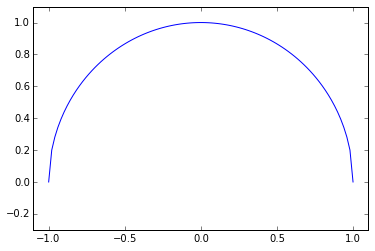

In [13]:
#your code here - you can recycle old plotting codes from previous Weekly Sessions
import matplotlib.pylab as plt
import numpy as np
%matplotlib inline


numPoints=100
x = np.linspace(-1,1,numPoints)
y=[]
for i in range(numPoints):
    y.append((1-x[i]**2)**0.5)
    
plt.plot(x,y)
plt.axis([-1.1,1.1,-0.3,1.1])
plt.show()

What is the analytically known value of the integral
$$
\int_{-1}^{1}\sqrt{1-x^2}\,dx?
$$
**Note:** You may quote results from elementary school without further proof.

In [14]:
import math

r=1
print(math.pi*(r**2)/2)

1.5707963267948966


To reach a tolerence of $10^{-10}$ with the trapezoidal rule, how many
iterations (and thus steps) are required?  Do you find that the
residual of your 
calculated result, relative to the known true value, is consistent with the
tolerance you asked for?  How about with Romberg extrapolation?

In [15]:
#your code here
import romberg

def squareRootArc (x):
    return (1-x**2)**0.5


tolerance=10**-10
interval=(-1,1)

romberg.romberg(squareRootArc,interval,tolerance,verbose=True)
integral_adaptive(squareRootArc,interval,tolerance,verbose=True)

integrating on range (-1, 1)

R(0,0) +0.000000000000000e+00

R(1,0) +1.000000000000000e+00 epsilon(1,0) +3.3333e-01
R(1,1) +1.333333333333333e+00

R(2,0) +1.366025403784439e+00 epsilon(2,0) +1.2201e-01
R(2,1) +1.488033871712585e+00 epsilon(2,1) +1.0313e-02
R(2,2) +1.498347240937868e+00

R(3,0) +1.497854534051220e+00 epsilon(3,0) +4.3943e-02
R(3,1) +1.541797577473481e+00 epsilon(3,1) +3.5842e-03
R(3,2) +1.545381824524207e+00 epsilon(3,2) +7.4658e-04
R(3,3) +1.546128405216054e+00

R(4,0) +1.544909572178587e+00 epsilon(4,0) +1.5685e-02
R(4,1) +1.560594584887709e+00 epsilon(4,1) +1.2531e-03
R(4,2) +1.561847718715324e+00 epsilon(4,2) +2.6136e-04
R(4,3) +1.562109082115183e+00 epsilon(4,3) +6.2669e-05
R(4,4) +1.562171751436356e+00

R(5,0) +1.561626518913870e+00 epsilon(5,0) +5.5723e-03
R(5,1) +1.567198834492298e+00 epsilon(5,1) +4.4028e-04
R(5,2) +1.567639117799270e+00 epsilon(5,2) +9.1927e-05
R(5,3) +1.567731044768857e+00 epsilon(5,3) +2.2047e-05
R(5,4) +1.567753091681224e+00 epsilon(5,4) +5

20

<div class=answer>
<div/>
**Romberg did the iteration in half the steps (ten versus twenty) that the adaptive integral did**

Looking back at the
Euler-Maclaurin formula, why might we expect this integral to be
problematic?

**Comment:**  Our whole analysis is based on the idea that the error in the trapezoidal rule is $O(h^2)$.  But occasionally the coefficient on $h^2$ can be important...


<div class=answer>
<div/>
**In this instance, the way that the interval is defined means that the endpoints result in divide by zero errors**

There is a further lesson to be learned here.   Sometimes just throwing numerical methods at a problem is not enough.  A little forethought can allow us to
transform the problem into one which is more amenable to numerical solution.  Try
making the trigonometric substitution $x=\cos u$.

You should have just found that the integral an equivalent to
$\int_0^\pi \sin^2 u\,du$.  Do we still expect trouble?  (Explain.)  

<div class=answer>
<div/>
The first order results in a chain rule derivation where the endpoints result in zero; however, this is not a divide by zero error, which gets us a little further.

How does this transformed integral fare with the Romberg method?

In [16]:
#your code here
def equalIntegral (x):
    return (np.sin(x))**2

romberg.romberg(equalIntegral,interval,tolerance,verbose=True)

integrating on range (-1, 1)

R(0,0) +1.416146836547142e+00

R(1,0) +7.080734182735712e-01 epsilon(1,0) -2.3602e-01
R(1,1) +4.720489455157141e-01

R(2,0) +5.838855562027158e-01 epsilon(2,0) -4.1396e-02
R(2,1) +5.424896021790973e-01 epsilon(2,1) +4.6960e-03
R(2,2) +5.471856459566561e-01

R(3,0) +5.548628372118389e-01 epsilon(3,0) -9.6742e-03
R(3,1) +5.451885975482132e-01 epsilon(3,1) +1.7993e-04
R(3,2) +5.453685305728210e-01 epsilon(3,2) -2.8843e-05
R(3,3) +5.453396874714902e-01

R(4,0) +5.477217189396392e-01 epsilon(4,0) -2.3804e-03
R(4,1) +5.453413461822392e-01 epsilon(4,1) +1.0183e-05
R(4,2) +5.453515294245076e-01 epsilon(4,2) -2.6986e-07
R(4,3) +5.453512595650105e-01 epsilon(4,3) +4.5381e-08
R(4,4) +5.453513049457694e-01

R(5,0) +5.459434313209865e-01 epsilon(5,0) -5.9276e-04
R(5,1) +5.453506687814357e-01 epsilon(5,1) +6.2151e-07
R(5,2) +5.453512902880487e-01 epsilon(5,2) -3.7958e-09
R(5,3) +5.453512864922319e-01 epsilon(5,3) +1.0560e-10
R(5,4) +5.453512865978287e-01 epsilon(5,4) -1

0.54535128657989329

<div class=answer>
<div/>
It solved it much faster, but also did not quite get to the correct answer.

## Exercise 5
### Life continues to be messy: Oscillatory integrands

One perpetual bane of physicists' existence is highly oscillator
integrands.  

Let us look at the integral
$$
\int_0^{2\pi} e^x \sin 100x \,dx.
$$
First, plot the integrand.  Comment on why it might be problematic.
Can you speculate on how many slices might be needed for successful evaluation?

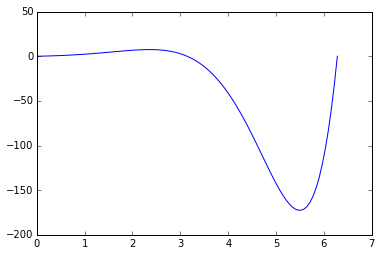

In [17]:
#your code here
def integrand(x):
    return np.exp(x)*np.sin(100*x)

numPoints=100
x = np.linspace(0,2*math.pi,numPoints)
y=[]
for i in range(numPoints):
    y.append(integrand(x[i]))
    
plt.plot(x,y)
plt.show()

<div class=answer>
<div/>
There are section of the graph where the terms preceeding an individual value exceed it in magnitude, while on other parts, the following terms are greater. Additionally, the slope varies wildly, along with the second derivative, as evidenced by the different curvatures.

Then, see how Romberg fares on this integral.  Comment.

In [18]:
#your code here

romberg.romberg(integrand,interval,tolerance,verbose=True)

integrating on range (-1, 1)

R(0,0) -1.190163011704795e+00

R(1,0) -5.950815058523973e-01 epsilon(1,0) +1.9836e-01
R(1,1) -3.967210039015981e-01

R(2,0) -4.342630574709246e-01 epsilon(2,0) +5.3606e-02
R(2,1) -3.806569080104337e-01 epsilon(2,1) +1.0709e-03
R(2,2) -3.795859682843561e-01

R(3,0) -3.932880334156766e-01 epsilon(3,0) +1.3658e-02
R(3,1) -3.796296920639273e-01 epsilon(3,1) +6.8481e-05
R(3,2) -3.795612110008268e-01 epsilon(3,2) +3.9297e-07
R(3,3) -3.795608180280724e-01

R(4,0) -3.829959955377480e-01 epsilon(4,0) +3.4307e-03
R(4,1) -3.795653162451051e-01 epsilon(4,1) +4.2917e-06
R(4,2) -3.795610245238503e-01 epsilon(4,2) +2.9600e-09
R(4,3) -3.795610215638983e-01 epsilon(4,3) -7.9818e-10
R(4,4) -3.795610223620781e-01

R(5,0) -3.804199670507940e-01 epsilon(5,0) +8.5868e-04
R(5,1) -3.795612908884760e-01 epsilon(5,1) +2.6836e-07
R(5,2) -3.795610225313674e-01 epsilon(5,2) +3.1627e-11
R(5,3) -3.795610224997407e-01 epsilon(5,3) -3.6700e-12
R(5,4) -3.795610225034107e-01 epsilon(5,4) -1

-0.37956102250354884

<div class=answer>
<div/>
I doubt this is the correct answer. A significant portion of the function lies under the x-axis, so the integral should be a much larger value.

Now try the integral
$$
\int_0^{2\pi} e^x \sin 128x \,dx.
$$
See how Romberg fares on this integral, and comment on why.
Please attach your plot of the integrand.

integrating on range (-1, 1)

R(0,0) +1.694728756087657e+00

R(1,0) +8.473643780438287e-01 epsilon(1,0) -2.8245e-01
R(1,1) +5.649095853625524e-01

R(2,0) +9.031034384582732e-01 epsilon(2,0) +1.8580e-02
R(2,1) +9.216831252630879e-01 epsilon(2,1) +2.3785e-02
R(2,2) +9.454680279231236e-01

R(3,0) +9.256106351771388e-01 epsilon(3,0) +7.5024e-03
R(3,1) +9.331130340834273e-01 epsilon(3,1) +7.6199e-04
R(3,2) +9.338750280047832e-01 epsilon(3,2) -1.8402e-04
R(3,3) +9.336910121330634e-01

R(4,0) -6.041614676967455e-03 epsilon(4,0) -3.1055e-01
R(4,1) -3.165923646283362e-01 epsilon(4,1) -8.3314e-02
R(4,2) -3.999060578757871e-01 epsilon(4,2) -2.1171e-02
R(4,3) -4.210771862230978e-01 epsilon(4,3) -5.3128e-03
R(4,4) -4.263900026872396e-01

R(5,0) +4.767133630387751e-02 epsilon(5,0) +1.7904e-02
R(5,1) +6.557565329749249e-02 epsilon(5,1) +2.5478e-02
R(5,2) +9.105352115921439e-02 epsilon(5,2) +7.7930e-03
R(5,3) +9.884653035024615e-02 epsilon(5,3) +2.0389e-03
R(5,4) +1.008854468858279e-01 epsilon(5,4) +5

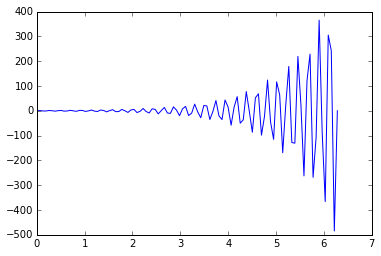

In [19]:
#your code here

def integrandDos(x):
    return np.exp(x)*np.sin(128*x)

romberg.romberg(integrandDos,interval,tolerance,verbose=True)
y=[]
for i in range(numPoints):
    y.append(integrandDos(x[i]))
    
plt.plot(x,y)
plt.show()

<div class=answer>
<div/>
**This one hovers around the zero in terms of the mean of the function, and thus the integral largely sums close to zero**

## Exercise 6
### Integrals over infinite ranges

Let us start by reproducing Newmans's Example 5.3 (on page 180).  But please ignore Newman's code for Gaussian integration.  Instead, we will continue to use our own Romberg integration function.

Integrands which involve the Gaussian $e^{-x^2}$ show up throughout
physics.  The basic Gaussian integral has a simple known value, so we
will use it as our test case (as we used last week ):
$$
\int_{-\infty}^\infty e^{-x^2}\,dx=\sqrt{\pi}.
$$

The integrand is symmetric, so we are free to consider just one half
($\int_{0}^\infty e^{-x^2}\,dx$), as Newman uses for his example, then
double the result.  Let us transform this integral according
to (5.67), to make sure we see how Newman got his expression.

**Sorry about the
overloading of Gauss's name. A "Gaussian integral" is an integral of
the Gaussian function.  "Gaussian integration" is integration by Gaussian
quadrature.  The two are not particularly related.**

<div class=answer>
<div/>
Answer here

Now try to evaluate the transformed integral using the Romberg
method.  What problem do you encounter, and how can you fix it?
It will help to make a plot of the integrand.

**Hint:** From looking at the plot,  what is the integrand's limit as $z\rightarrow 1$?


In [ ]:
#your code here

<div class=answer>
<div/>
Answer here

Finally, how does the Romberg method fare on the integral? Explain.

In [ ]:
#your code here

<div class=answer>
<div/>
Answer here

Plot your transformed integrand.

In [ ]:
#your code here

## Numerical differentiation

** Newman Exercise 5.15 **

Create a user-defined function ```f(x)``` that returns the value $1 + \frac{1}{2} \tanh(2x)$, then use a central difference to calculate the derivative of the function in the range $-2\le x\le2$.  Calculate an analytic formula for the derivative and make a graph with your numerical result and the analytic answer on the same plot.  It may help to plot the exact answer as lines and the numerical one as dots.  

**Hint:** In Python the ```tanh``` function is found in the ```math``` package, and it's called simply ```tanh```.

Please attach your code and plots.


In [ ]:
#your code here